In [4]:
import pickle
from collections import defaultdict
from osmxtract import overpass, location
import pandas as pd
import folium
import numpy as np
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point,Polygon,MultiLineString,MultiPolygon,LineString,shape
from area import area

In [7]:
#this function takes lat lon and return map showing buffer geometry and also gives the buffer bounds
def make_map(lat, lon):   
    #make map and sorround by circle
    m = folium.Map([lat, lon], zoom_start=15)
    folium.Marker([lat, lon]).add_to(m)
    #folium.Circle([lat, lon],radius=1000,color='red').add_to(m)
    folium.LatLngPopup().add_to(m)
    
    #calculate bounds value of sorrounding bounds value
    bounds = location.from_buffer(lat, lon, buffer_size=564)  #564 is equal to 1 km sq
    proj_wgs84 = pyproj.Proj(init='epsg:4326')
    def geodesic_point_buffer(lat, lon, km):
        # Azimuthal equidistant projection
        aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
        project = partial(
            pyproj.transform,
            pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
            proj_wgs84)
        buf = Point(0, 0).buffer(km * 564)  # distance in metres
        return transform(project, buf).exterior.coords[:]

    bound_points = np.array(geodesic_point_buffer(lat, lon, 1))
    buffer_geom = Polygon(zip(bound_points[:, 0],bound_points[:, 1]))
    folium.GeoJson(buffer_geom).add_to(m)
    
    return m,bounds,buffer_geom

#this function calculates the distance betweenn two points on geographical map. it takes lat-lng of two points and
#returns distanc ein meters (before calling this fuinction converts, lat/lng to radians through the function to_radian)
def distance_between_points(lat1,lon1,lat2,lon2):
    #R is earth diameter in meters
    R = 6371000
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance 
def to_radians(theta):
    return np.divide(np.dot(theta, np.pi), np.float32(180.0))

def to_degrees(theta):
    return np.divide(np.dot(theta, np.float32(180.0)), np.pi)

# the function plots a shape and buffer. the buffer must be polygon while shape can be any of the following if statemenst 
def plot(poly,buffer_geom=0):
    plt.figure()
    if poly.geom_type=='Polygon':
        x,y=poly.exterior.coords.xy
        plt.plot(x,y)
    elif poly.geom_type=='LineString':
        x,y=np.array(shape(poly).coords.xy)
        plt.plot(x,y)
    elif poly.geom_type=='MultiPolygon':
        for pol in poly:
            x,y=pol.exterior.coords.xy
            plt.plot(x,y)
    elif poly.geom_type=='MultiLineString':
        for pol in poly:
            x,y=np.array(shape(pol).coords.xy)
            plt.plot(x,y)
        
    if buffer_geom!=0:
        x,y =buffer_geom.exterior.coords.xy
        plt.plot(x,y)
    plt.show()

# this function calculates the difference. if there is a new polygon, it is tested whether it crossed the boundry with
#with old polygon or not. if it crosess than the differnce is find out and returned.
def calculate_diff(All_polygons,new_poly,diff_polys):
    for prev_poly in All_polygons:
        diff=new_poly.difference(prev_poly)
        if (diff.is_empty):
            continue
        else:
            if diff not in diff_polys:
                diff_polys.append(diff)
    return diff_polys


# this function is only calls the above calculate_diff function 
def for_both_line_poly(new_line,buffer_geom,All_lines):
        diff_lines=[]
        if new_line.geom_type == 'Polygon' or new_line.geom_type == 'LineString':
                diff_lines=calculate_diff(All_lines,new_line,diff_lines)

        elif new_line.geom_type == 'MultiPolygon'or new_line.geom_type == 'MultiLineString':
            for line in new_line:
                diff_lines=calculate_diff(All_lines,line,diff_lines)
        return diff_lines

    
#This functions calculates intersection of polygon with buffer, then checks whether this polygon already cross boundry
# with old polygons or not by calling "for_both_line_poly" function. it then finds athe area with "PIarea" library. 
# Then add it to previous similar type of areas and updates feature dictionary
def poly_area(features,poly,buffer_geom,nam,All_polygons):
    total_area=0  

    if poly.is_valid:
        new_poly=poly.intersection(buffer_geom)
    else:
        poly=poly.buffer(0)
        new_poly=poly.intersection(buffer_geom)
    
    #NO intersection is found so return
    if new_poly.is_empty:
        return features,All_polygons
    #plot(new_poly,buffer_geom)
    #now chek for overlap with all previous lines/polygon and subtract if there is overlap
    diff_polys=for_both_line_poly(new_poly,buffer_geom,All_polygons)
    
    #if there is no difference among the polys, it means they dont cross  we will take original overlap line/poly
    if len(diff_polys)<1:
        diff_polys.append(new_poly)

    #calculate the length of all the lines extracted
    for poly in diff_polys:
        
        if poly.geom_type == 'Polygon':
            All_polygons.append(poly)
            obj = {'type':'Polygon','coordinates':[list(np.array(poly.exterior.coords.xy).T)]}
            total_area=total_area+area(obj)
        else:
            for n_poly in poly:
                All_polygons.append(n_poly)
                obj = {'type':'Polygon','coordinates':[list(np.array(n_poly.exterior.coords.xy).T)]}
                total_area=total_area+area(obj)       
            
    try:
        features[nam]=features[nam]+total_area
    except:
        features[nam]=total_area
    return features,All_polygons
        
#this function calucaltes length of line in meters from starting to ending point by iterating through all the points
# a series of 'lat/lon line points is given and it returns length in meters 
def line_distance(coords):
    start_point=coords[0]
    total_dist=0
    for ic in coords:
        dist=distance_between_points(to_radians(start_point[0]),to_radians(start_point[1]),to_radians(ic[0]),to_radians(ic[1]))
        total_dist=total_dist+dist
        start_point=ic
    return total_dist

#This functions calculates intersection of line with buffer, then checks whether this line already cross boundry
# with old polygons or not by calling "for_both_line_poly" function. it then finds the length with "line_distance" 
#function. Then add it to previous similar type of line and updates feature dictionary
def line_length(line_features,line,buffer_geom,nam,All_lines):
    total_dist=0  
    
    new_line=line.intersection(buffer_geom)
    #NO intersection is found so return
    if new_line.is_empty:
        return line_features,All_lines

    #now chek for overlap with all previous lines/polygon and subtract if there is overlap
    diff_lines=for_both_line_poly(new_line,buffer_geom,All_lines)
    
    
    #if there is no difference among the lines/polys, it means they dont cross  we will take original overlap line/poly
    if len(diff_lines)<1:
        diff_lines.append(new_line)
    #calculate the length of all the lines extracted
    for line in diff_lines:
        if line.geom_type == 'LineString':
            All_lines.append(line)
            dist=line_distance(np.array(shape(line).coords))
            total_dist=total_dist+dist
        else:
            for n_line in line:
                All_lines.append(n_line)
                dist=line_distance(np.array(shape(n_line).coords))
                total_dist=total_dist+dist  
                

    #save it to the features 
    try:
        line_features[nam]=line_features[nam]+total_dist
    except:
        line_features[nam]=total_dist

        
    return line_features,All_lines

#this function extarcts the geometry from the repsonse and then then sseparates lines and polygon structure. then call
#"poly_area" function for calulating area or "line_length" function for finding length. this function deals with "way" structures
#returned from the map
def poly_line_features(poly_features,line_features,linestr,buffer_geom,tags):
    All_lines=[]
    All_polygons=[]
    
    for i,fi in enumerate(linestr['features']):
        coords=fi["geometry"]["coordinates"]
        if len(coords)==0:
            continue
        else:
            nam=fi['properties'][tags]
            
            if len(coords)>2:
                if coords[0]==coords[-1]:
                    poly_features,All_polygons=poly_area(poly_features,Polygon(coords),buffer_geom,nam,All_polygons)
                    
                else:
                    line_features,All_lines=line_length(line_features,LineString(coords),buffer_geom,nam,All_lines)

    return poly_features,line_features,All_polygons,All_lines

#This function deals with "realtion" structure of osm. as these are multipolygons so we need one additional iteration,
#it combines all the polygons for single area, converts it to valid polygon and then find the area and add it to feature 
#dictionary
def multi_poly_area(features,multi,buffer_geom,tags,All_polygons):
    for i,fi in enumerate(multi['features']):
        
        coords=fi["geometry"]["coordinates"]
        allpoly=[]
        for each_poly in coords[0]:
            if len(each_poly)==0:
                continue
            else:
                allpoly.extend(each_poly)
        else:
            
            nam=fi['properties'][tags]
            if len(allpoly)>2:
#                 pl=np.array(allpoly).T
#                 plt.figure()
#                 plt.plot(pl[0],pl[1])
                try:
                    allpoly=(Polygon(allpoly)).buffer(0)
                except:
                    print("already a polygon")
                features,All_polygons=poly_area(features,allpoly,buffer_geom,nam,All_polygons) 
    return features,All_polygons

#this functions deals with "node" structure of osm. it counts the numeber of nodes of each type.
def point_counts(point_features,poi,tags):
    All_points=[]
    for i,fi in enumerate(poi['features']):
        nam=fi['properties'][tags]
        coords=fi["geometry"]["coordinates"]
        new_poly=Point(coords).intersection(buffer_geom)
        if new_poly.geom_type=='Point':
            All_points.append(coords)
            try :
                point_features[nam]=point_features[nam]+1
            except:
                point_features[nam]=1
    return point_features,All_points

#this function takes a tag value and bounds and returns all  the nodes, way and relations in a buffer area.
def get_query_response(bounds,tags):
    query = overpass.ql_query(bounds, tag=tags)
    response = overpass.request(query)
    try:
        multi= overpass.as_geojson(response, 'multipolygons')
    except:
        multi=0
    try:
        poi= overpass.as_geojson(response, 'point')
    except:
        poi=0
    try:
        linestr= overpass.as_geojson(response, 'linestring')
    except:
        linestr=0
    #folium.GeoJson(multi).add_to(map1) 
    return poi,linestr,multi



# the file geodata is already made, we just open it read it and assign all features to dict and then add other features along the way
# if the script is running for "first time"  comment the below 3 lines. if program fails somewhere, remember to uncomment it,
# and run the program otherwise you will lose initially asaved data
#####
import pickle

infile = open("geodata_all_sensors_2017.pkl",'rb')
old_dict = pickle.load(infile)
#old_dict={}
combinefeatures =old_dict
####

#programs iterates through all sensor locations , get the kilometer buffer and extarct all the information.
#combinefeatures =old_dict
#all_locations=pd.read_csv('../airbox data/airbox/device_locations.csv')
airbox2017=pd.read_csv("../airbox data/airbox/airbox-2017.csv")
all_locations=airbox2017[['device_id','lat','lon']].drop_duplicates(keep='last')
not_collected=[]
for i,loc in enumerate(all_locations.iterrows()):
    
    if loc[1][0] in list(old_dict.keys()):
        continue
    else:
        try:
            lat, lon=loc[1][1],loc[1][2]
            map1,bounds,buffer_geom=make_map(lat, lon)
            point_features={}
            poly_features={}
            line_features={}
            multi_features={}
            try:
                print(i)
                for tags in ['amenity','public_transport','shop', 'craft', 'office','building','highway','industrial','natural','leisure','junction','power','sports']:
                    poi,linestr,multi=get_query_response(bounds,tags)
                    if poi!=0:
                        point_features,All_points=point_counts(point_features,poi,tags)
                    if linestr!=0:
                        poly_features,line_features,All_polygons,All_lines=poly_line_features(poly_features,line_features,linestr,buffer_geom,tags)
                    if multi!=0:
                        poly_features,All_polygons=multi_poly_area(poly_features,multi,buffer_geom,tags,All_polygons)
                    combinefeatures[loc[1][0]]=[point_features,line_features,poly_features]
                    print(tags)
                    if i%10==0:
                        f = open("geodata_all_sensors_2017.pkl","wb")
                        pickle.dump(combinefeatures,f)
                        f.close()
            except:
                not_collected.append(loc[1][0])
                continue
        except:
            continue
  
    

41
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
53
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
57
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
72
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
772
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
773
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
775
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
776
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
781
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction


amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1075
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1076
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1078
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1079
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1080
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1081
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1082
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1083
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
j

junction
power
sports
1185
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1186
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1187
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1188
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1189
amenity
public_transport
shop
1193
amenity
public_transport
shop
craft
office
1194
amenity
public_transport
shop
1196
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
1197
amenity
public_transport
shop
craft
office
building
1198
amenity
public_transport
shop
craft
1200
amenity
public_transport
shop
craft
office
building
highway
industrial
1201
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1202
amenity
public_transport
12

amenity
public_transport
shop
craft
office
building
highway
1399
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
1401
amenity
public_transport
1402
amenity
1403
amenity
public_transport
1405
amenity
public_transport
shop
craft
office
building
highway
1407
1408
amenity
public_transport
1410
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
1413
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1417
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
1419
amenity
public_transport
1420
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1421
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1422
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junct

sports
1568
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1569
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1571
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1573
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1577
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1578
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1581
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1582
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1584
amenity
public_transport
shop
craft
office
building
highway
industrial
natur

junction
power
sports
1711
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1712
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1717
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1718
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1720
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1726
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1727
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1728
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1729
amenity
public_transport
shop
craft
office
building
highway
i

shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1813
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1814
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1815
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1816
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1817
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1819
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1821
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1822
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1824

shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1917
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1918
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1919
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1920
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1921
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1923
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1924
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1926
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1927

shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
1999
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2000
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2001
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2004
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2005
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2006
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2007
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2008
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2009

public_transport
shop
craft
office
2103
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2104
amenity
2105
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2107
amenity
public_transport
2109
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2111
amenity
public_transport
shop
craft
office
2112
amenity
public_transport
shop
craft
office
building
highway
2113
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2115
2116
amenity
public_transport
2117
amenity
public_transport
shop
craft
2118
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2119
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2122
amenity
public_transport
shop
craft
office
b

shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2205
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2206
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2207
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2208
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2210
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2211
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2212
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2213
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2214

shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2283
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2284
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2285
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2286
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2287
amenity
public_transport
shop
craft
2289
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2290
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2291
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2292
amenity
public_transport
shop
craft
office
building
highway
industrial
n

industrial
natural
2370
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2371
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2372
amenity
2373
amenity
public_transport
2374
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2375
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2376
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2377
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2378
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2379
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2381
amenity
2382
amenity


junction
power
sports
2505
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2506
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2507
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2508
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2509
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2510
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2511
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2513
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2514
amenity
public_transport
shop
craft
office
building
highway
i

leisure
junction
power
sports
2583
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2584
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2585
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2586
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2587
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2588
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2589
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2590
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2591
amenity
public_transport
shop
craft
office
building
h

leisure
junction
power
sports
2668
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2669
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2670
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2671
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2672
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2673
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2674
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2675
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2676
amenity
public_transport
shop
craft
office
building
h

natural
leisure
junction
power
sports
2791
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2792
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2793
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2794
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2795
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2796
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2797
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2798
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2799
amenity
public_transport
shop
craft
office
bu

industrial
natural
leisure
junction
power
sports
2869
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2871
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2872
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2873
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2874
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2875
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2876
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2877
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2878
amenity
public_transport
shop
craf

highway
industrial
natural
leisure
junction
power
sports
2953
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2954
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2955
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2956
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2957
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2958
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2959
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2960
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
2961
amenity
public_transport
s

power
sports
3059
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3061
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3063
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3067
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3068
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3070
amenity
public_transport
shop
craft
3072
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3073
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3074
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3075
amenity
public_transport
shop

natural
leisure
junction
power
sports
3185
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3187
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3188
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3189
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3190
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3191
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3192
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3193
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3194
amenity
public_transport
shop
craft
office
bu

industrial
natural
leisure
junction
power
sports
3324
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3325
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3327
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3328
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3329
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3330
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3331
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3332
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3333
amenity
public_transport
shop
craf

power
sports
3438
amenity
3440
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3441
amenity
3443
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3444
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3446
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3447
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3448
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3450
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3451
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3452
amenity
public_transport
shop
craft
office
b

industrial
natural
leisure
junction
power
sports
3552
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3553
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3555
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3556
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3557
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3558
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3559
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3562
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3563
amenity
public_transport
shop
craf

highway
industrial
natural
leisure
junction
power
sports
3646
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3649
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3650
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3653
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3655
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3656
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3659
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3661
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3664
amenity
public_transport
s

building
highway
industrial
natural
leisure
junction
power
sports
3775
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3776
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3778
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3779
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3783
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3786
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3788
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3790
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3791
amenity
public_tr

industrial
natural
leisure
junction
power
sports
3910
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3911
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3912
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3913
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3914
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3915
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3916
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3917
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
3918
amenity
public_transport
shop
craf

highway
industrial
natural
leisure
junction
power
sports
4019
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4020
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4021
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4022
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4023
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4024
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4026
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4027
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4028
amenity
public_transport
s

shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4126
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4127
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4128
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4131
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4132
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4133
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4134
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4136
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4137

natural
leisure
junction
power
sports
4229
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4231
amenity
public_transport
shop
4232
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4233
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4234
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4235
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4236
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4237
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4239
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4241
amenity
pu

industrial
natural
leisure
junction
power
sports
4345
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4346
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4347
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4348
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4349
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4351
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4352
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4353
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4354
amenity
public_transport
shop
craf

natural
leisure
junction
power
sports
4449
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4450
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4451
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4454
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4456
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4457
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4458
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4460
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4461
amenity
public_transport
shop
craft
office
bu

leisure
junction
power
sports
4551
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4552
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4553
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4554
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4555
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
4556
amenity
public_transport
shop
craft
4557
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4558
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4559
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4560
amenity
public_transport
shop
craft
office

industrial
natural
leisure
junction
power
sports
4649
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4650
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4651
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4652
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4653
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4654
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4655
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4656
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4658
amenity
public_transport
shop
craf

building
highway
industrial
4752
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4753
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4754
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4755
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4758
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4759
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4762
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4763
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4764
amenity
public_transport
shop
craft
office
building
hig

natural
leisure
junction
power
sports
4863
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4864
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4865
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4866
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4869
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4870
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4871
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4874
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4876
amenity
public_transport
shop
craft
office
bu

industrial
natural
leisure
junction
power
sports
4966
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4967
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4971
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4973
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4974
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4975
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4976
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4978
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
4979
amenity
public_transport
shop
craf

industrial
natural
leisure
junction
power
sports
5072
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5073
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5074
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5075
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5077
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5079
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5080
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5081
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5082
amenity
public_transport
shop
craf

highway
industrial
natural
leisure
junction
power
sports
5166
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5167
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5168
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5169
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5170
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5172
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5173
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5176
amenity
public_transport
shop
craft
office
building
highway
industrial
natural
leisure
junction
power
sports
5177
amenity
public_transport
s

In [ ]:
import pickle
infile = open("geodata.pkl",'rb')
new_dict = pickle.load(infile)
len(list(new_dict.keys()))

# Visualization of single buffer

In [ ]:

all_locations=pd.read_csv('../airbox data/airbox/device_locations.csv')

for i,loc in enumerate(all_locations.iterrows()):
    lat, lon=loc[1][2],loc[1][3]
map1,bounds,buffer_geom=make_map(lat, lon)

point_features={}
poly_features={}
line_features={}
multi_features={}
psss=[]
polyss=[]
liness=[]
map1,bounds,buffer_geom=make_map(lat, lon)
for tags in ['amenity','public_transport','shop', 'craft', 'office','building','highway','industrial','natural','leisure','junction','power','sports']:
    poi,linestr,multi=get_query_response(bounds,tags)
    point_features,All_points=point_counts(point_features,poi,tags)
    poly_features,line_features,All_polygons,All_lines=poly_line_features(poly_features,line_features,linestr,buffer_geom,tags)
    poly_features,All_polygons=multi_poly_area(poly_features,multi,buffer_geom,tags,All_polygons)
    polyss=polyss+All_polygons
    liness=liness+All_lines
    psss=psss+All_points
    
for po in psss:
    folium.Marker([po[1],po[0]]).add_to(map1)
map1

In [ ]:
map1,bounds,buffer_geom=make_map(lat, lon)
for po in polyss:
    array=np.array(po.exterior.coords.xy).T 
    array[:,[0, 1]] = array[:,[1, 0]]
    folium.PolyLine(array).add_to(map1)
map1

In [ ]:
map1,bounds,buffer_geom=make_map(lat, lon)
for po in liness:
    array=np.array(po.coords.xy).T 
    array[:,[0, 1]] = array[:,[1, 0]]
    folium.PolyLine(array).add_to(map1)
map1

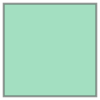

In [5]:
from shapely.geometry import Point,Polygon,MultiLineString,MultiPolygon
import numpy as np
po1=np.array([[0,1],[0,2],[0,3],[0,4],[1,4],[2,4],[3,4],[3,3],[3,1],[2,1],[1,1],[0,1]])
a=Polygon(po1)
a

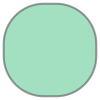

In [6]:
a.buffer(10)

In [ ]:
import matplotlib.pyplot as plt
po1=np.array([[0,1],[0,2],[0,3],[0,4],[1,4],[2,4],[3,4],[3,3],[3,1],[2,1],[1,1],[0,1]])
a=Polygon(po1)
po1=po1.T
plt.plot(po1[0],po1[1])
po=np.array([[1,3],[2,3],[4,4],[4,1],[3,1],[1,3]])
b=Polygon(po)
po=po.T

plt.plot(po[0],po[1])
plt.show()
inter=b.intersection(a)
x,y=inter.exterior.coords.xy
plt.figure()
plt.plot(po1[0],po1[1])
plt.plot(x,y)
plt.show()